In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# find pixel
def findPixel(img, linep1, linep2, linep3):
    pixels = []
    height, width = img.shape[:2]
    for i in range (height):
        for j in range (width):
            if (int(i*linep1+j*linep2+linep3) == 0):
                pixels.append([i, j])
    return pixels

# compute ssd 
def SSD (patch, pt, img):
    pt_x, pt_y  = pt[:]
    patch_new = img[pt_y-2:pt_y+3, pt_x-2:pt_x+3]
    dif = 0.0
    if((img.shape[1]-2 > pt_x > 1) & (img.shape[1]-2 > pt_y > 1)):
        for p in range (5):
            for q in range (5):
                dif = (int(patch[p][q])- int(patch_new[p][q]))**2 + dif
    return dif

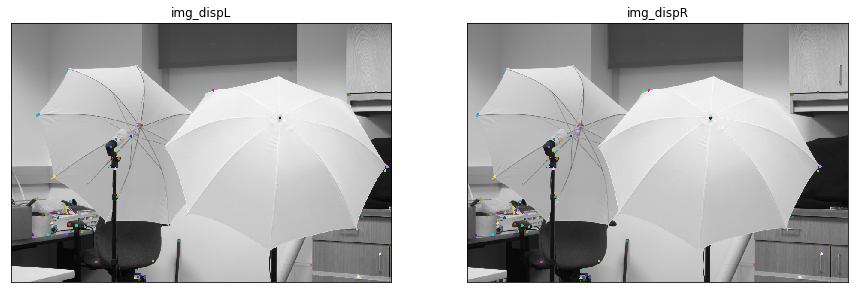

In [145]:
# read the image 
img_Left = cv2.imread("0.png", cv2.IMREAD_GRAYSCALE);
img_Right = cv2.imread("1.png", cv2.IMREAD_GRAYSCALE);

# resize the image
img_Left = cv2.resize(img_Left, None, fx=0.3, fy=0.3)
img_Right = cv2.resize(img_Right, None, fx=0.3, fy=0.3)

# Find the sift points
sift = cv2.xfeatures2d.SIFT_create()

# compute the siftpoint
kpL, desL = sift.detectAndCompute(img_Left, None)
kpR, desR = sift.detectAndCompute(img_Right, None)

bfMatcher = cv2.BFMatcher(cv2.NORM_L2)
matches = bfMatcher.knnMatch(desL, desR, k=2)

good = []
pts_Left = []
pts_Right = []

# store the matches
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts_Right.append(kpR[m.trainIdx].pt)
        pts_Left.append(kpL[m.queryIdx].pt)

pts_Left = np.int32(pts_Left)
pts_Right = np.int32(pts_Right)
F, mask = cv2.findFundamentalMat(pts_Left, pts_Right, cv2.FM_LMEDS)

# get the matched points
pts_Left = pts_Left[mask.ravel()==1]
pts_Right = pts_Right[mask.ravel()==1]

# covert the image into RGB
img_dispL = cv2.cvtColor(img_Left, cv2.COLOR_GRAY2BGR)
img_dispR = cv2.cvtColor(img_Right, cv2.COLOR_GRAY2BGR)

# circle the matched points
for pt1, pt2 in zip(pts_Left, pts_Right):
# pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        # draw the points
        img_dispL = cv2.circle(img_dispL, tuple(pt1), 3, color, -1)
        img_dispR = cv2.circle(img_dispR, tuple(pt2), 3, color, -1)    

# display image
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_dispL, cmap="gray")
plt.title("img_dispL"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_dispR, cmap="gray")
plt.title("img_dispR"), plt.xticks([]), plt.yticks([])
plt.show()

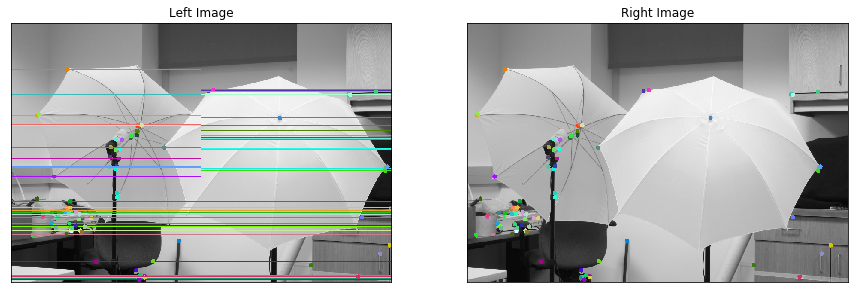

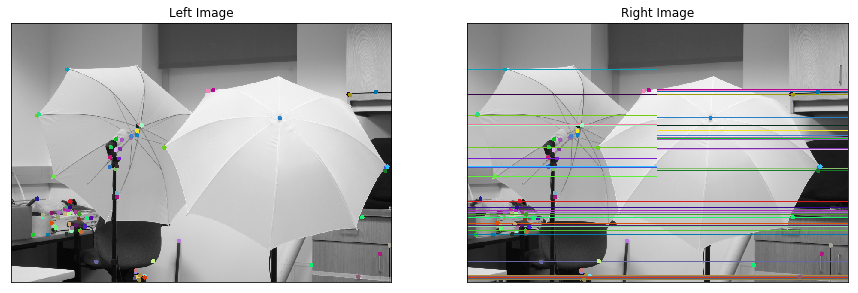

In [146]:
# compute the lines
linesL = cv2.computeCorrespondEpilines(pts_Right, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(img_Left, img_Right, linesL, pts_Left, pts_Right)
# compute the lines
linesR = cv2.computeCorrespondEpilines(pts_Left, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(img_Right, img_Left, linesR, pts_Right, pts_Left)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Pick any one keypoint in the right image which doesn’t have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the right image. 

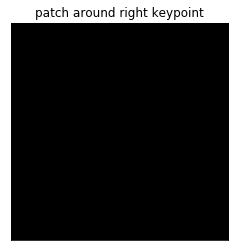

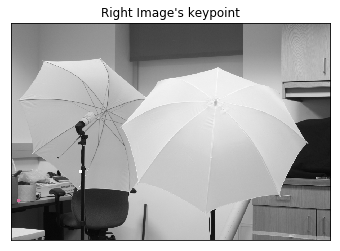

In [150]:
good = []
ptsL = []
ptsR = []
# find the points that don't match 
for i, (m, n) in enumerate(matches):
    if m.distance > 0.7 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
        
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations 
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

ptsR=ptsR[19:20]

# find the corrsponding lines
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

# draw lines
imgL1, imgR1 = drawlines(img_Left, img_Right, linesL, pts_Left, pts_Right)
# draw the keypoints
x, y = ptsR[0]
keypoint = img_Right[y-2:y+3, x-2:x+3]

# display image
plt.imshow(keypoint, cmap="gray")
plt.title("5x5 patch"), plt.xticks([]), plt.yticks([])
plt.show()

# display images)
plt.imshow(imgR1, cmap="gray")
plt.title("Right Image's keypoint"), plt.xticks([]), plt.yticks([])
plt.show()


-0.020854795 0.9997825 -401.23676 [[-2.0854795e-02  9.9978250e-01 -4.0123676e+02]]


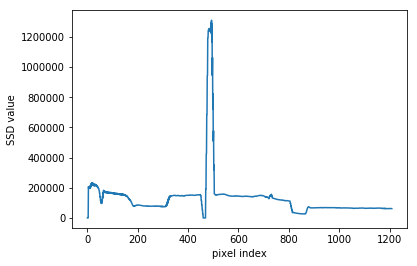

In [156]:
#find ssd
linep1 = linesL[0][0]
linep2 = linesL[0][1]
linep3 = linesL[0][2]
 
pixels = findPixel(img_Left, linep1, linep2, linep3)
diff = np.zeros(len(pixels))
for i in range (len(pixels)):
    diff[i] = SSD(keypoint, pixels[i], img_Left)     

ssd = diff
minimum = np.amin(ssd)
mini_idx = np.argmin(ssd)

plt.plot(ssd)
plt.xlabel('pixel index') 
plt.ylabel('SSD value') 
plt.show()

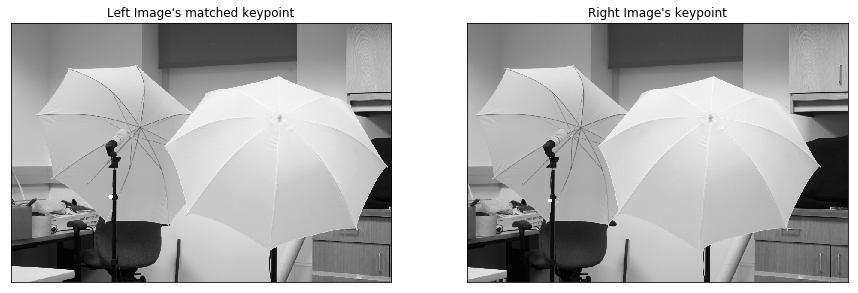

In [149]:
matching=pixels[mini_idx]

ptsL_match = ptsL
ptsL_match[0] = matching
ptsR_match = ptsR

# display the matching points
color = tuple(np.random.randint(0, 255, 3).tolist())
imgL1_match = cv2.circle(img_Left, tuple(ptsL_match[0]), 5, (255,4,87), -1)
imgR1_match = cv2.circle(img_Right, tuple(ptsR_match[0]), 5, (255,4,87), -1)


plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1_match, cmap="gray")
plt.title("Left Image's matched keypoint"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1_match , cmap="gray")
plt.title("Right Image's keypoint"), plt.xticks([]), plt.yticks([])
plt.show()

2.2.6 Did you find exactly one matching point with lowest SSD or multiple? Is
the found matching point correct one? Explain why. 

I found exactly one matching, it is the correct one!

Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single
match?

We can decrease the size of the patch. Also, in the mean time, we can also increase the sharpness of the image so that the matching point found will be more accurate. 

Suppose you found exactly one match with the lowest SSD, but it is incor-
rect one. What constraint(s) could be imposed to find a correct match?

We can increase the size of the patch so that more matching points will be found. Also, we can use the built-in library to find more accurate points